In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys

'do nothing' if 'np' not in globals() else np.set_printoptions(3, suppress=True);

ITEM = "3909"

LABEL_PATH = "/home/nupdm/Datasets/nuPDM/routes_training_new_mini/route_route0_routes_training_date_05_23_11_36_25/labels/" + ITEM + ".txt"
CAM_FRONT_PATH = "/home/nupdm/Datasets/nuPDM/routes_training_new_mini/route_route0_routes_training_date_05_23_11_36_25/CAM_FRONT/" + ITEM + ".jpg"
CAM_FRONT_INSTANCE_PATH = "/home/nupdm/Datasets/nuPDM/routes_training_new_mini/route_route0_routes_training_date_05_23_11_36_25/CAM_FRONT_INST/" + ITEM + ".png"
CALIB_PATH = "/home/nupdm/Datasets/nuPDM/routes_training_new_mini/route_route0_routes_training_date_05_23_11_36_25/calib/" + ITEM + ".txt"


with open(LABEL_PATH, 'r') as f:
    lines = f.readlines()
    labels = [line.strip() for line in lines if line.strip()]

print(lines)
# label format is class, h, w, l, x, y, z, yaw, num_pts

with open(CALIB_PATH, 'r') as f:
    lines = f.readlines()
    calib = [line.strip() for line in lines if line.strip()]
    cam_front_k = []
    lidar2cam_front = []
    for line in calib:
        if line.startswith('CAM_FRONT_K:'):
            cam_front_k = [float(x) for x in line.split()[1:]]
            cam_front_k = np.array(cam_front_k).reshape(4, 4)
        elif line.startswith('LIDAR2CAM_FRONT:'):
            lidar2cam_front = [float(x) for x in line.split()[1:]]
            lidar2cam_front = np.array(lidar2cam_front).reshape(4, 4)
        elif line.startswith('LIDAR2EGO:'):
            lidar2ego = [float(x) for x in line.split()[1:]]
            lidar2ego = np.array(lidar2ego).reshape(4, 4)

# open and show image
img = cv2.imread(CAM_FRONT_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
plt.imshow(img)
plt.axis('off')

FileNotFoundError: [Errno 2] No such file or directory: '/home/nupdm/Datasets/nuPDM/routes_training_new/route_route0_routes_training_date_05_22_10_20_10/labels/3909.txt'

len objects: 3
cls: car, w: 1.8118125200271606, h: 1.441947340965271, l: 4.673638820648193, x: 25.54329545053986, y: 1.6809338703731385, z: 0.013076122876960028, yaw: -2.9788966804874355
cls: static_trafficwarning, w: 3.0, h: 3.555742025375366, l: 2.5, x: 7.496835721764626, y: 1.5000405965597707, z: 0.020063491994179117, yaw: -1.407640625509364
len bboxes_2d_list: 2
bboxes_2d_list: [(820, 452, 925, 526), (804, -16, 1362, 786)]


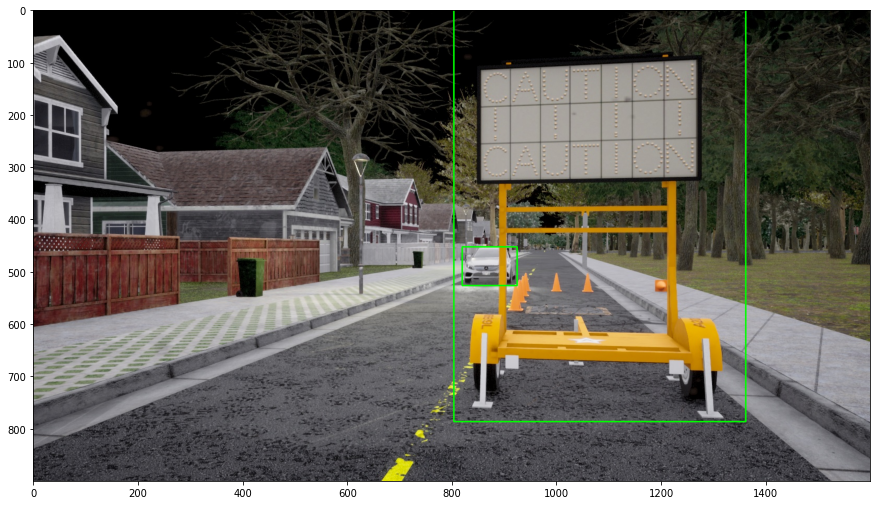

In [47]:
def get_3d_box(w, h, l, x, y, z, yaw):
    # 8 vértices en coordenadas locales del objeto (x delante, y izquierda, z arriba)
    x_corners = [ l/2,  l/2, -l/2, -l/2,  l/2,  l/2, -l/2, -l/2]
    y_corners = [ w/2,  w/2,  w/2,  w/2, -w/2, -w/2, -w/2, -w/2]
    z_corners = [ h, 0, 0, h, h, 0, 0, h]  # z=0 en la base y z=h en el techo

    corners = np.array([x_corners, y_corners, z_corners])  # shape (3, 8)

    # Rotación alrededor del eje Z (yaw en radianes)
    R = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw),  np.cos(yaw), 0],
        [0,           0,            1]
    ])

    # Aplicar rotación y traslación
    corners_3d = R @ corners
    corners_3d += np.array([[x], [y], [z]])
    return corners_3d.T  # shape (8, 3)

def transform_to_cam(corners_ego, ego2cam):
    corners_hom = np.concatenate([corners_ego, np.ones((8,1))], axis=1).T  # shape (4, 8)
    corners_cam = ego2cam @ corners_hom  # shape (4, 8)
    return corners_cam[:3].T  # shape (8, 3)

def project_to_image(corners_cam, cam2img):
    corners_hom = np.concatenate([corners_cam, np.ones((8,1))], axis=1).T  # shape (4, 8)
    img_points = cam2img @ corners_hom  # shape (3, 8)
    img_points = img_points[:2] / img_points[2]
    return img_points.T  # shape (8, 2)

def draw_box(image, img_pts, color=(0, 255, 0), thickness=2):
    img_pts = img_pts.astype(int)

    # Conecta los vértices para formar las aristas
    connections = [
        (0, 1), (1, 2), (2, 3), (3, 0),  # base
        (4, 5), (5, 6), (6, 7), (7, 4),  # techo
        (0, 4), (1, 5), (2, 6), (3, 7)   # verticales
    ]
    
    for i, j in connections:
        pt1, pt2 = tuple(img_pts[i]), tuple(img_pts[j])
        cv2.line(image, pt1, pt2, color, thickness)
    
    return image

# draw 2d bbox from 3d corners
def get_2d_bbox_and_depth(img_pts, corners_cam):
    u_min = int(np.min(img_pts[:, 0]))
    v_min = int(np.min(img_pts[:, 1]))
    u_max = int(np.max(img_pts[:, 0]))
    v_max = int(np.max(img_pts[:, 1]))
    bbox = (u_min, v_min, u_max, v_max)

    # Profundidad media (Z en coordenadas cámara)
    depth = np.mean(corners_cam[:, 2])
    return bbox, depth

def draw_bbox_2d(image, bbox, color=(0, 255, 0), thickness=2):
    u_min, v_min, u_max, v_max = bbox
    cv2.rectangle(image, (u_min, v_min), (u_max, v_max), color, thickness)
    return image

# get each label
objects = []
for line in labels:
    label = line.split()
    if len(label) == 9:
        objects.append(label)

lidar2cam = lidar2cam_front
ego2cam = lidar2cam @ np.linalg.inv(lidar2ego)
cam2img = cam_front_k[:3, :]

# draw all boxes in the same img
img = cv2.imread(CAM_FRONT_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

bboxes_2d_list = []
corners_3d_list = []
orig_corners_3d_list = []
depths_list = []
print(f"len objects: {len(objects)}")
for object in objects:
    cls, w, h, l, x, y, z, yaw, num_pts = object

    # print(f"cls: {cls}, w: {w}, h: {h}, l: {l}, x: {x}, y: {y}, z: {z}, yaw: {yaw}, num_pts: {num_pts}")
    # x front, y left, z up
    # draw only if x > 1
    if float(x) < 0.5:
        continue

    x = float(x)
    y = float(y)
    z = float(z)
    h = float(h)
    w = float(w)
    l = float(l)
    yaw = float(yaw)

    print(f"cls: {cls}, w: {w}, h: {h}, l: {l}, x: {x}, y: {y}, z: {z}, yaw: {yaw}")

    corners_3d = get_3d_box(w, h, l, x, y, z, yaw)
    corners_3d_list.append(corners_3d)
    corners_cam = transform_to_cam(corners_3d, ego2cam)
    corners_2d = project_to_image(corners_cam, cam2img)

    # 3D
    # img = draw_box(img, corners_2d)
    
    # 2D
    bbox_2d, depth = get_2d_bbox_and_depth(corners_2d, corners_cam)
    bboxes_2d_list.append(bbox_2d)
    depths_list.append(depth)
    img_with_bbox = draw_bbox_2d(img, bbox_2d)

print(f"len bboxes_2d_list: {len(bboxes_2d_list)}")
print(f"bboxes_2d_list: {bboxes_2d_list}")

# save bbox_2d_list as npy
np.save(f"dataset_scripts/bboxes_2d_list_{ITEM}.npy", bboxes_2d_list) 

fig = plt.figure(figsize=(15, 15))
plt.imshow(img)

In [48]:
print(f"corners_3d: {corners_3d_list}")

print(f"bboxes_2d: {bboxes_2d_list}")

print(f"depths: {depths_list}")

corners_3d: [array([[23.384,  0.408,  1.455],
       [23.384,  0.408,  0.013],
       [27.996,  1.166,  0.013],
       [27.996,  1.166,  1.455],
       [23.091,  2.196,  1.455],
       [23.091,  2.196,  0.013],
       [27.703,  2.953,  0.013],
       [27.703,  2.953,  1.455]]), array([[9.18 , 0.51 , 3.576],
       [9.18 , 0.51 , 0.02 ],
       [8.774, 2.977, 0.02 ],
       [8.774, 2.977, 3.576],
       [6.22 , 0.023, 3.576],
       [6.22 , 0.023, 0.02 ],
       [5.814, 2.49 , 0.02 ],
       [5.814, 2.49 , 3.576]])]
bboxes_2d: [(820, 452, 925, 526), (804, -16, 1362, 786)]
depths: [24.787295450539858, 6.7408357217646255]


u_min: 804, v_min: -16, u_max: 1362, v_max: 786
u_min: 820, v_min: 452, u_max: 925, v_max: 526


(-0.5, 1599.5, 899.5, -0.5)

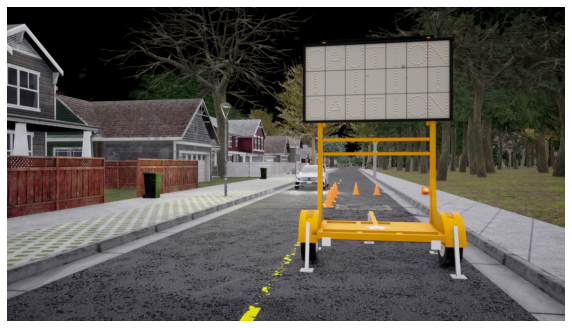

In [49]:
# filter occlusions
def filter_occluded_boxes(bboxes, depths, image_shape, threshold=0.8):
    """
    bboxes: lista de (u_min, v_min, u_max, v_max)
    depths: lista de profundidades (mismo orden que bboxes)
    image_shape: (H, W) de la imagen
    threshold: porcentaje de oclusión permitido (0.8 = 80%)
    """

    H, W = image_shape
    mask = np.zeros((H, W), dtype=np.uint8)

    # Ordenar por profundidad (cerca a lejos)
    sorted_idx = np.argsort(depths)
    visible_boxes = []

    for idx in sorted_idx:
        u_min, v_min, u_max, v_max = bboxes[idx]

        print(f"u_min: {u_min}, v_min: {v_min}, u_max: {u_max}, v_max: {v_max}")

        # Get rid of VERY boxes (very close to the camera)
        # if u_min < 0 or v_min < 0 or u_max >= W or v_max >= H:
        #     continue

        u_min, v_min = max(0, u_min), max(0, v_min)
        u_max, v_max = min(W - 1, u_max), min(H - 1, v_max)

        # Calcular área total de la caja
        area_total = (u_max - u_min + 1) * (v_max - v_min + 1)
        if area_total <= 0:
            continue

        # Calcular área ya ocupada (ocluida) en el mask
        mask_crop = mask[v_min:v_max + 1, u_min:u_max + 1]
        area_occluded = np.count_nonzero(mask_crop)

        oclusion_ratio = area_occluded / area_total

        if oclusion_ratio <= threshold:
            visible_boxes.append(idx)
            # Marcar esta caja como visible
            mask[v_min:v_max + 1, u_min:u_max + 1] = 1

    return visible_boxes

# Filtrar cajas ocluidas
visible_boxes = filter_occluded_boxes(bboxes_2d_list, depths_list, img.shape[:2], threshold=0.8)

img = cv2.imread(CAM_FRONT_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
# Mostrar cajas visibles
# for idx in visible_boxes:
#     u_min, v_min, u_max, v_max = bboxes_2d_list[idx]
#     print(f"u_min: {u_min}, v_min: {v_min}, u_max: {u_max}, v_max: {v_max}")
#     img_2 = cv2.rectangle(img, (u_min, v_min), (u_max, v_max), (255, 0, 0), 2)

# fig = plt.figure(figsize=(20, 20))
# plt.imshow(img_2)
# plt.axis('off')

In [50]:
for idx in visible_boxes:
    print(f"bbox: {bboxes_2d_list[idx]}")

bbox: (804, -16, 1362, 786)
